In [1]:
import logging
import os
import pickle
import random
from copy import copy
from typing import Any, Callable, Optional

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pm4py
import pm4py.ocel
import skorch
import torch
import torch.nn.functional as F
import torch.optim as O
import torch_geometric as tg
import torch_geometric.transforms as T
import torch_geometric.utils as utils
from pm4py.algo.transformation.ocel.features.objects import (
    algorithm as object_feature_factory,
)
from torch import Tensor
from torch_geometric.data import HeteroData
from torch_geometric.datasets import FakeHeteroDataset
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import (
    GATConv,
    GCNConv,
    HeteroConv,
    HGTConv,
    Linear,
    SAGEConv,
    to_hetero,
)
from torch_geometric.typing import (
    DEFAULT_REL,
    EdgeTensorType,
    EdgeType,
    FeatureTensorType,
    NodeType,
    QueryType,
    SparseTensor,
)

os.chdir("/home/tim/Development/OCPPM/")
from bpi17_ofg import BPI17_OFG

raw_file = "data/BPI17/feature_encodings/OFG/ofg/raw/BPI17_OFG_all_feats.pkl"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    filename="logging/debug.log",
)
logging.critical("-" * 64)
import torch
import torch.nn.functional as F
import torch.optim as O
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GATConv, Linear, to_hetero

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/tim/Development/OCPPM/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = BPI17_OFG('data/BPI17/feature_encodings/OFG')
dataset.get_summary()

BPI17_OFG (#graphs=1):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    74504 |   129553 |
| std        |      nan |      nan |
| min        |    74504 |   129553 |
| quantile25 |    74504 |   129553 |
| median     |    74504 |   129553 |
| quantile75 |    74504 |   129553 |
| max        |    74504 |   129553 |
+------------+----------+----------+

In [103]:
with open(raw_file, 'rb') as hetero_data_pkl:
    hetero_data: HeteroData = pickle.load(hetero_data_pkl)
hetero_data = T.AddSelfLoops()(hetero_data)
hetero_data = T.NormalizeFeatures()(hetero_data)
hetero_data = T.ToUndirected()(hetero_data)
hetero_data['application'].x = hetero_data['application'].x.to(torch.float)
hetero_data['application'].y = hetero_data['application'].y.to(torch.float)
hetero_data['offer'].x = hetero_data['offer'].x.to(torch.float)
hetero_data['offer'].y = hetero_data['offer'].y.to(torch.float)

In [104]:
edge_types = [
    ("application", "interacts", "application"),
    ("application", "interacts", "offer"),
    ("offer", "interacts", "offer"),
]
data = T.RandomNodeSplit(
    # num_val=0.1, num_test=0.1, edge_types=edge_types, neg_sampling_ratio=0.0
)(hetero_data)

In [105]:
train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors = {key: [16] * 2 for key in data.edge_types},
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=128,
    input_nodes=('application', data['application'].train_mask),
    # input_nodes=('offer', data['offer'].train_mask),
)

batch1 = next(iter(train_loader))
batch1

HeteroData(
  application={
    y=[64],
    x=[64, 62],
    train_mask=[64],
    val_mask=[64],
    test_mask=[64],
    n_id=[64],
    input_id=[64],
    batch_size=64
  },
  offer={
    y=[104],
    x=[104, 62],
    train_mask=[104],
    val_mask=[104],
    test_mask=[104],
    n_id=[104]
  },
  (application, interacts, application)={
    edge_index=[2, 64],
    e_id=[64]
  },
  (application, interacts, offer)={
    edge_index=[2, 104],
    e_id=[104]
  },
  (offer, interacts, offer)={
    edge_index=[2, 174],
    e_id=[174]
  },
  (offer, rev_interacts, application)={
    edge_index=[2, 104],
    e_id=[104]
  }
)

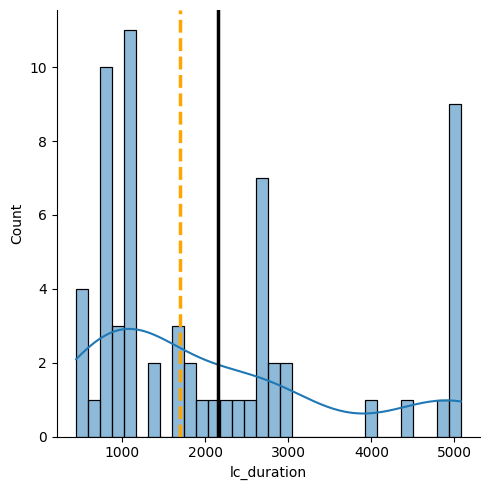

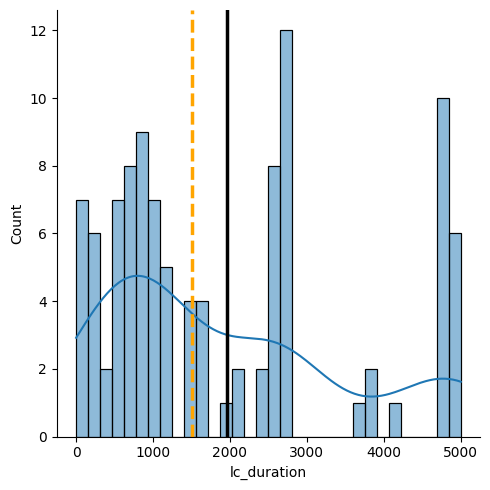

In [106]:
import seaborn as sns
def specs(x, **kwargs):
    plt.axvline(x.mean(), c='k', ls='-', lw=2.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)

y = batch1['application'].y
durations = pd.DataFrame({'lc_duration': y/1000})
g = sns.displot(durations, x='lc_duration', kde=True, bins=32,facet_kws=dict(sharey=False, sharex=False))
g.map(specs, 'lc_duration')
y = batch1['offer'].y
durations = pd.DataFrame({'lc_duration': y/1000})
g = sns.displot(durations, x='lc_duration', kde=True, bins=32,facet_kws=dict(sharey=False, sharex=False))
g.map(specs,'lc_duration' )


In [107]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x



model = GAT(hidden_channels=128, out_channels=1)
model = to_hetero(model, data.metadata(), aggr='sum')
optimizer = O.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
model.to(DEVICE)

GraphModule(
  (conv1): ModuleDict(
    (application__interacts__application): GATConv((-1, -1), 128, heads=1)
    (application__interacts__offer): GATConv((-1, -1), 128, heads=1)
    (offer__interacts__offer): GATConv((-1, -1), 128, heads=1)
    (offer__rev_interacts__application): GATConv((-1, -1), 128, heads=1)
  )
  (lin1): ModuleDict(
    (application): Linear(-1, 128, bias=True)
    (offer): Linear(-1, 128, bias=True)
  )
  (conv2): ModuleDict(
    (application__interacts__application): GATConv((-1, -1), 1, heads=1)
    (application__interacts__offer): GATConv((-1, -1), 1, heads=1)
    (offer__interacts__offer): GATConv((-1, -1), 1, heads=1)
    (offer__rev_interacts__application): GATConv((-1, -1), 1, heads=1)
  )
  (lin2): ModuleDict(
    (application): Linear(-1, 1, bias=True)
    (offer): Linear(-1, 1, bias=True)
  )
)

In [108]:
def train_one_epoch(i: int, verbose: bool):
    total_examples = total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(DEVICE)
        batch_size = batch["application"].batch_size
        # batch_size = batch["offer"].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.mse_loss(
            # out["offer"][:batch_size], batch["offer"].y[:batch_size]
            out["application"][:batch_size], batch["application"].y[:batch_size]
        )
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size
    
    avg_loss = total_loss / total_examples
    if verbose:
        print(f"Epoch: {i}, Average Loss: {avg_loss}")
    
    return avg_loss

def train(num_epochs: int, verbose: bool = True) -> list[float]:
    # model.double()
    model.train()
    losses_per_epoch = []
    for epoch in range(num_epochs):
        losses_per_epoch.append(train_one_epoch(i=epoch+1, verbose=verbose))

    return losses_per_epoch

In [118]:
avg_train_loss = train(150, verbose=False)
avg_train_loss

/tmp/ipykernel_4763/3827497592.py:9: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(
/tmp/ipykernel_4763/3827497592.py:9: UserWarning: Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(


[1253483611928.9866,
 1253469374032.6157,
 1253465806202.4592,
 1253463458712.5046,
 1253461799762.2112,
 1253460894701.949,
 1253460205528.9631,
 1253459596807.8655,
 1253459115463.6458,
 1253458956510.073,
 1253458813704.0957,
 1253458684042.881,
 1253458568871.698,
 1253458508277.8142,
 1253458449077.2449,
 1253458341167.4568,
 1253458295725.3198,
 1253458244757.971,
 1253458205797.5845,
 1253458185900.2705,
 1253458171167.8284,
 1253458150172.0237,
 1253458122838.6045,
 1253458100038.9163,
 1253458068877.1587,
 1253458036536.107,
 1253458037547.2424,
 1253458028093.234,
 1253457996492.5168,
 1253457969796.79,
 1253457954361.1392,
 1253457934592.6738,
 1253457916905.4446,
 1253457897121.6924,
 1253457876466.5725,
 1253457852286.6736,
 1253457834581.9731,
 1253457820915.2637,
 1253457797434.2056,
 1253457776685.179,
 1253457746416.6274,
 1253457746960.4133,
 1253457723881.1887,
 1253457704125.827,
 1253457673577.739,
 1253457662409.386,
 1253457638679.3657,
 1253457617495.7476,
 1253

In [154]:
loss_app_100epochs

[2822632381959.251,
 2780875126388.24,
 2739127686663.865,
 2697440968981.8984,
 2655856470316.488,
 2614410973496.158,
 2573130790725.8926,
 2532048508901.043,
 2491192953341.867,
 2450588374750.9775,
 2410259476933.291,
 2370235455225.73,
 2330541624757.492,
 2291198607678.3003,
 2252235008114.3125,
 2213675239600.28,
 2175547398226.7827,
 2137876509486.177,
 2100681751482.423,
 2063993135691.7363,
 2027839220778.4832,
 1992244028535.5332,
 1957234916577.2466,
 1922835224719.3853,
 1889072350567.4868,
 1855971827308.8015,
 1823557313341.0547,
 1791852638386.1226,
 1760887498637.0051,
 1730686951079.766,
 1701273753384.6833,
 1672673224331.3076,
 1644909386869.9636,
 1618006056777.3733,
 1591986817249.4172,
 1566871757081.4473,
 1542684874281.7156,
 1519445336803.5156,
 1497173727999.9744,
 1475887109136.4814,
 1455603306980.1384,
 1436339953442.6094,
 1418110032068.3442,
 1400923553794.1838,
 1384789917073.0488,
 1369716188133.2134,
 1355705789234.0671,
 1342756991036.739,
 133086358

In [117]:
loss_app_100epochs_offer_sampling = torch.tensor(avg_train_loss) / 1_000_000_000_000
loss_app_100epochs_offer_sampling[:50]

tensor([4.8238, 4.8183, 4.8064, 4.7877, 4.7632, 4.7337, 4.7000, 4.6622, 4.6207,
        4.5755, 4.5267, 4.4744, 4.4187, 4.3599, 4.2983, 4.2339, 4.1669, 4.0974,
        4.0252, 3.9507, 3.8740, 3.7955, 3.7151, 3.6332, 3.5498, 3.4652, 3.3796,
        3.2930, 3.2057, 3.1179, 3.0300, 2.9419, 2.8540, 2.7664, 2.6794, 2.5931,
        2.5078, 2.4238, 2.3412, 2.2603, 2.1813, 2.1044, 2.0299, 1.9578, 1.8885,
        1.8222, 1.7591, 1.6994, 1.6431, 1.5906])

In [ ]:

# model = GAT(hidden_channels=64, out_channels=1)
# model = to_hetero(model, dataset[0].metadata(), aggr='sum')

model = HeteroGNN(hidden_channels=64, out_channels=1, num_layers=2)

model.double()

In [18]:
def train(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data["offer"].train_mask
    loss = loss_fn(out["offer"][mask], data["offer"].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

optimizer = O.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
loss = train(model, dataset[0], optimizer, F.mse_loss)

IndexError: too many indices for tensor of dimension 2

In [ ]:
G = nx.Graph()
G.add_edges_from(graph)
some_graph = {x for x in graph if "Application_2114646933" in x}
sorted_cc = sorted(list(nx.connected_components(G)), key=len, reverse=True)
sg = G.subgraph(sorted_cc[4])
# sg = nx.Graph()
# sg.add_edges_from(some_graph_adjacency)
nx.draw(sg, with_labels=True)
plt.savefig("../../tests/objects_interaction_graph.png")

In [5]:
from torch_geometric.datasets import OGB_MAG

dataset = OGB_MAG(root="./data", preprocess="metapath2vec")
citation_network = dataset[0]
citation_network

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389]
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)

In [6]:
dataset.num_classes

349

In [8]:
# testing to check whether we can indicate correct nodes from each node type in the edge_index
orders = {"price": [1250, 678], "discount": [33, 0], "black_friday_sale": [1, 0]}
items = {"weight": [3.5, 3.0, 26.0], "size": [2, 2, 3]}
order_x_tensor = torch.tensor(list(orders.values()))[1:].T
order_y_tensor = torch.tensor(list(orders.values()))[
    0
].T  # order_price will be the target
item_x_tensor = torch.tensor(list(items.values())).T
# o_o_interaction = torch.tensor([[],[]])
o_i_interaction = torch.tensor(
    [[0, 0, 1], [0, 1, 2]]
)  # directional (only from order to item)
i_i_interaction = torch.tensor([[2, 1], [1, 2]])
test_het = HeteroData(
    {"order": {"x": order_x_tensor, "y": order_y_tensor}, "item": {"x": item_x_tensor}},
    #   order__interacts_with__order={'edge_index': o_o_interaction},
    order__interacts_with__item={"edge_index": o_i_interaction},
    item__interacts_with__item={"edge_index": i_i_interaction},
)

/tmp/ipykernel_5995/2265959475.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  order_y_tensor = torch.tensor(list(orders.values()))[


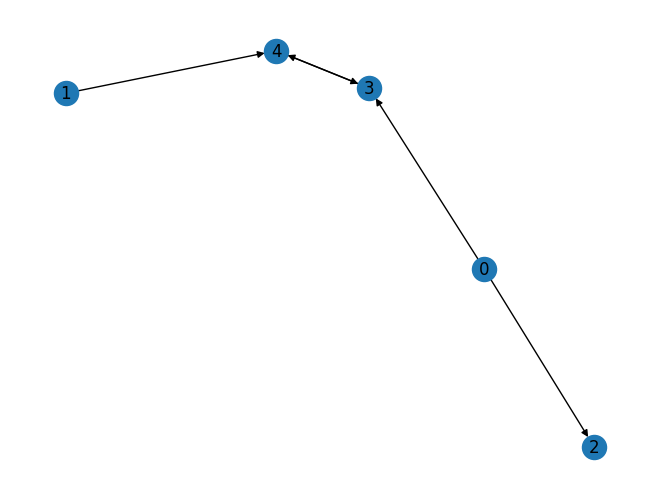

In [9]:
test_het
g = utils.to_networkx(test_het.to_homogeneous(), to_undirected=False)
nx.draw(g, with_labels=True)

In [ ]:
fake_het = FakeHeteroDataset(
    num_node_types=2,
    num_edge_types=3,
    avg_num_nodes=2.5,
    num_classes=2,
    avg_degree=1,
    avg_num_channels=3,
)
fake_het = fake_het[0]
# fake_het.generate_ids()
fake_het

In [ ]:
fake_het["v0"]

In [ ]:
fake_het
fake_het.to_dict()

In [ ]:
fake_het["(v1, e0, v1)"]

In [ ]:
# define a format for the adjacency matrix (use real oid or custom object_index?)

In [ ]:
# Define HeteroData in PyG, using offer_features, application_features, and the adjacency matrix

In [ ]:
# build OFG class that can hold features
# enable this class to be ported to PyG


In [ ]:
# COULD MOVE THIS TO A UNIT TEST FILE
# example_edges = [('o1','i1'),('o1','i2'),('i2','i3'),('i3','o2')]
# test_split = split_on_edge_types(edge_list=to_undirected(example_edges), edge_types=[('o','i'), ('i','i')])
# test_split
